<a href="https://colab.research.google.com/github/FischerMoseley/ball_boi/blob/main/SingleDOFNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook Setup 
The following cell will install Drake, checkout the underactuated repository, and set up the path (only if necessary).
- On Google's Colaboratory, this **will take approximately two minutes** on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  Colab will ask you to "Reset all runtimes"; say no to save yourself the reinstall.
- On Binder, the machines should already be provisioned by the time you can run this; it should return (almost) instantly.

More details are available [here](http://underactuated.mit.edu/drake.html).

In [50]:
import importlib
import sys
from urllib.request import urlretrieve

# Install drake (and underactuated).
if 'google.colab' in sys.modules and importlib.util.find_spec('underactuated') is None:
    urlretrieve(f"http://underactuated.csail.mit.edu/scripts/setup/setup_underactuated_colab.py",
                "setup_underactuated_colab.py")
    from setup_underactuated_colab import setup_underactuated
    setup_underactuated(underactuated_sha='3e23b46200d113f9432c17b17751e16e7b42c995', drake_version='0.27.0', drake_build='release')

# Setup matplotlib.
from IPython import get_ipython
if get_ipython() is not None: get_ipython().run_line_magic("matplotlib", "inline")

In [51]:
# python libraries
import numpy as np
from IPython.display import HTML, display
from matplotlib import pyplot
import pydrake.all
from pydrake.all import (
    DiagramBuilder, LinearQuadraticRegulator, Saturation, SceneGraph, Simulator, MakeVectorVariable, Variable,
    WrapToSystem, AddMultibodyPlantSceneGraph, Parser, MathematicalProgram,MultibodyPlant, PlanarSceneGraphVisualizer, MultibodyForces_,
    Expression,DecomposeLumpedParameters, VectorSystem, LogOutput,DiscreteAlgebraicRiccatiEquation
)

from underactuated.jupyter import AdvanceToAndVisualize, SetupMatplotlibBackend, running_as_notebook
import numpy as np
from ipywidgets import FloatSlider, ToggleButton
from IPython.display import display, SVG
import pydot

# underactuated imports
from underactuated import FindResource, ManipulatorDynamics

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [52]:
# unstable equilibrium point
x_star = [0, 0, 0, 0]

# weight matrices for the lqr controller*
Q = np.diag((10., 10., 1., 1.))
R = np.eye(1)
timestep = 0.1

In [53]:
ballbot_urdf = """
<?xml version="1.0"?>

<robot xmlns="http://drake.mit.edu"
 xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
 name="BallBot">

  <link name="ground">
    <visual>
      <origin xyz="0 0 -5" rpy="0 0 0" />
      <geometry>
        <box size="1000 1000 10" />
      </geometry>
      <material>
        <color rgba="0.93 .74 .4 1" />
      </material>
    </visual>
  </link>

  <joint name="ground_weld" type="fixed">
    <parent link="world" />
    <child link="ground" />
  </joint>

  <link name="ball">
    <inertial>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <mass value="5" />
      <inertia ixx=".2" ixy="0" ixz="0" iyy="0.2" iyz="0" izz="0.2" />
    </inertial>
    <visual>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <geometry>
        <sphere radius=".1" />
      </geometry>
      <material>
        <color rgba="0.25 0.52 0.96 1" />
      </material>
    </visual>
  </link>

  <link name="bot">
    <inertial>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <mass value="4" />
      <inertia ixx="0.10" ixy="0" ixz="0" iyy="0.18" iyz="0" izz="0.1" />
    </inertial>
    <visual>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <geometry>
         <cylinder length=".1" radius=".12" />
      </geometry>
      <material>
        <color rgba=".61 .63 .67 1" />
      </material>
    </visual>
  </link>
  
  <joint name="x" type="prismatic">
    <parent link="world" />
    <child link="ball" />
    <origin xyz="0 0 .1" />
    <axis xyz="1 0 0" />
    <dynamics damping="0.1" />
  </joint>
   

  <joint name="theta1" type="continuous">
    <parent link="ball" />
    <child link="bot" />
    <origin xyz="0 0 0" />
    <axis xyz="0 1 0" />
    <dynamics damping="0.1" />
  </joint>


  <transmission type="SimpleTransmission" name="ball_torque">
    <actuator name="torque" />
    <joint name="theta1" />
    <mechanicalReduction>1</mechanicalReduction>
  </transmission>

  <transmission type="SimpleTransmission" name="ball_force">
    <actuator name="force" />
    <joint name="x" />
    <mechanicalReduction>.1</mechanicalReduction>
  </transmission>
</robot>
"""

Now that we've successfully constructed a URDF file, we can add it to LQR and run our robot!

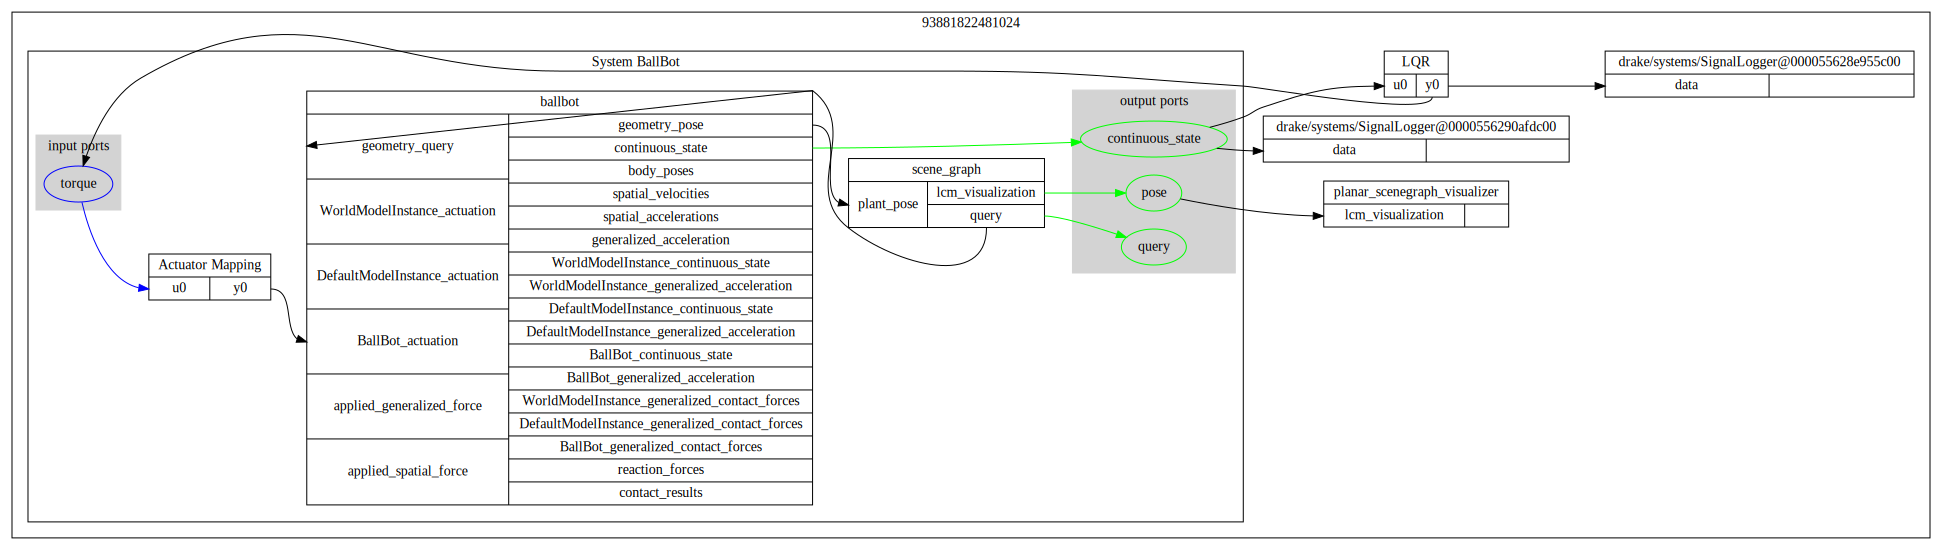

In [54]:
# start construction site of our block diagram
builder = DiagramBuilder()

# instantiate the cart-pole and the scene graph
def BallBot():
  builder = DiagramBuilder()
  ballbot, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
  Parser(ballbot).AddModelFromString(ballbot_urdf, "urdf")
  ballbot.set_name("ballbot")
  ballbot.Finalize()

  B = np.array([[1],[1]])

  gain = builder.AddSystem(pydrake.systems.primitives.MatrixGain(B))
  gain.set_name("Actuator Mapping")

  builder.Connect(gain.get_output_port(),ballbot.get_actuation_input_port())
  builder.ExportInput(gain.get_input_port(),"torque")
  builder.ExportOutput(ballbot.get_state_output_port(), "continuous_state")
  builder.ExportOutput(scene_graph.get_query_output_port(), "query")
  builder.ExportOutput(scene_graph.get_pose_bundle_output_port(), "pose")

  return builder.Build(),scene_graph

ballbotsystem,scene_graph = BallBot()
ballbotsystem.set_name("System BallBot")
ballbotsystem = builder.AddSystem(ballbotsystem)

#now we need to add a connection between the ground and the top

# set the operating point (vertical unstable equilibrium)
context = ballbotsystem.CreateDefaultContext()
context.get_mutable_continuous_state_vector().SetFromVector(x_star)

# fix the input port to zero and get its index for the lqr function
ballbotsystem.get_input_port().FixValue(context, [0])
input_i = ballbotsystem.get_input_port().get_index()
log = LogOutput(ballbotsystem.get_output_port(0),builder)

# synthesize lqr controller directly from
# the nonlinear system and the operating point

lqr= LinearQuadraticRegulator(ballbotsystem, context, Q, R, input_port_index=input_i)
lqr = builder.AddSystem(lqr)
lqr.set_name("LQR")
log2 = LogOutput(lqr.get_output_port(0),builder)
# wire cart-pole and lqr
builder.Connect(ballbotsystem.GetOutputPort("continuous_state"), lqr.get_input_port(0))
builder.Connect(lqr.get_output_port(0), ballbotsystem.get_input_port())

# add a visualizer and wire it
visualizer = builder.AddSystem(
    PlanarSceneGraphVisualizer(scene_graph, xlim=[-3., 2.], ylim=[-.4, 1.5], show=False)
)


builder.Connect(ballbotsystem.GetOutputPort("pose"), visualizer.get_input_port(0))

# finish building the block diagram
diagram = builder.Build()
display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))
# instantiate a simulator
simulator = Simulator(diagram)
simulator.set_publish_every_time_step(False) # makes sim faster


In [55]:
sys = pydrake.systems.primitives.FirstOrderTaylorApproximation(ballbotsystem, context)

def quadratic_regulator_solution(xt, timestep):
  S = DiscreteAlgebraicRiccatiEquation(sys.A(),sys.B(),
                                       Q=Q, R=R)
  print(S)
  return xt.matmul(torch.from_numpy(S).float().matmul(xt.transpose(-2,-1)))


pos = torch.tensor([.5,.5,0,0],dtype=torch.float).unsqueeze(0).unsqueeze(0).unsqueeze(0)
print(quadratic_regulator_solution(pos,0.1))

print(net(pos))

[[ 1.00000000e+01  1.45239700e-14  8.53571956e-15  9.09183710e-15]
 [ 1.45239700e-14  1.45641417e+01  3.24269252e-02 -2.45803022e-01]
 [ 8.53571956e-15  3.24269252e-02  1.10014258e+01 -2.02542909e-03]
 [ 9.09183710e-15 -2.45803022e-01 -2.02542909e-03  1.55734697e+01]]
tensor([[[[6.1410]]]])
tensor([[[[3.3871]]]], grad_fn=<AddBackward0>)


In [56]:
# function that given the cart-pole initial state
# and the simulation time, simulates the system
# and produces a video
def simulate_and_animate(x0, sim_time=10):
    
    # start recording the video for the animation of the simulation
    visualizer.start_recording()
    
    # reset initial time and state
    context = simulator.get_mutable_context()
    context.SetTime(0.)
    context.SetContinuousState(x0)
    
    


    # run sim
    simulator.Initialize()
    simulator.AdvanceTo(sim_time)
    
    # stop video
    visualizer.stop_recording()
    
    # construct animation
    ani = visualizer.get_recording_as_animation()
    
    # display animation below the cell
    display(HTML(ani.to_jshtml()))
    
    # reset to empty video
    visualizer.reset_recording()
    #visualize postiions
    times = log.sample_times()
    verticies = np.vstack([times,log.data()[0,:]])

    pyplot.plot(verticies[0,:],verticies[1,:])  

    #times2 = log2.sample_times()
    #verticies2 = np.vstack([times,log2.data()[0,:]])

    #pyplot.plot(verticies2[0,:],verticies2[1,:])  
    

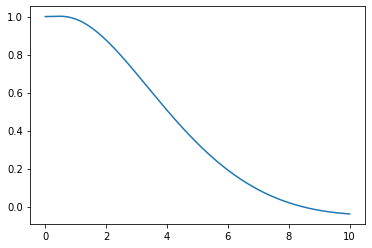

In [57]:
# simulate and animate the cart
pyplot.clf()
simulate_and_animate(np.array([1, -0.2, 0, 0]))


Ok so from this example we just have a regular ball bot. Now we need to make a  new distribution of things to look at


In [58]:
#defining cost to go

Qt = torch.from_numpy(Q)
Rt = torch.from_numpy(R)
Qt =Qt.type(torch.FloatTensor)
Rt =Rt.type(torch.FloatTensor)
def quadratic_regulator_cost(x,u):
  G = x.matmul(Qt.matmul(x.transpose(-2,-1))) + u*Rt*u.transpose(-2,-1)

  #G = G + x[:,:,:,1].abs().gt(np.pi/4).unsqueeze(-1)*30
  return G

In [59]:
#This will get us EOM so we can actually do things with them.

ballbot = ballbotsystem.GetSubsystemByName("ballbot").ToSymbolic()
context = ballbot.CreateDefaultContext()
q = MakeVectorVariable(2,"q")
v = MakeVectorVariable(2,"v")
vd = MakeVectorVariable(2,"vd")
u = Variable("u")
forces = MultibodyForces_[Expression](ballbot)
ballbot.CalcForceElementsContribution(context, forces)

ballbot.get_actuation_input_port().FixValue(context, [u,u])
ballbot.SetPositions(context,q)
ballbot.SetVelocities(context,v)

M = ballbot.CalcMassMatrixViaInverseDynamics(context)
eom = ballbot.CalcInverseDynamics(context,vd,forces) - ballbot.MakeActuationMatrix()@[u,u]
#print(eom)
#print(M)
#eom[0] = -eom[0].Substitute({vd[0]:0,vd[1]:0})
#eom[1] = -eom[1].Substitute({vd[0]:0,vd[1]:0})

Cv = ballbot.CalcBiasTerm(context)
tauG = ballbot.CalcGravityGeneralizedForces(context)


#print(M.dot(vd) + Cv - tauG -ballbot.MakeActuationMatrix()@[u,u])
#print(M)
#print(eom)
M, Cv, tauG, B, tauExt = ManipulatorDynamics(ballbot,q,v)
#to fudge this we are just going to solve this quickly ourselves 
#insted of a mass matrix I'll just evalute this all from scratch
#The reason for this is just to make it much faster to test everything

print(M.dot(vd) + Cv - tauG -B@[u,u] - tauExt)
print(B)



[<Expression "(0.10000000000000001 * v(0) + 9 * vd(0) - u - 0.20000000000000001 * (pow(v(1), 2) * sin(q(1))) + 0.20000000000000001 * (vd(1) * cos(q(1))))">
 <Expression "(0.10000000000000001 * v(1) + 0.19 * vd(1) - u + 0.20000000000000001 * (vd(0) * cos(q(1))) - 1.9620000000000002 * sin(q(1)))">]
[[<Expression "0"> <Expression "1">]
 [<Expression "1"> <Expression "0">]]


In [60]:
timestep = 0.1

In [61]:
ballbot_context = ballbot.CreateDefaultContext()
xs = torch.linspace(-.4,1.5,15)
thetas = torch.linspace(-np.pi/2,np.pi,15)
xdots = torch.linspace(-1,1,15)
thetadots = torch.linspace(-1,1,15)
us = torch.linspace(-1,1,9)


XS, THETAS, XDOTS, THETADOTS, US = torch.meshgrid(xs, thetas,xdots,thetadots,us)
# Want x as batch row vectors... size [num_state_samples, 1, num_states]
# (because the linear units in net expect row vectors)
X = torch.stack((XS.flatten(), THETAS.flatten(),XDOTS.flatten(),THETADOTS.flatten(),US.flatten()), 1)

print(X.shape)
#for i in range(X.shape[0]):
# Xnext[i,:,:] = torch.tensor(getNextState(X[i,:,0:4].numpy().flatten(),X[i,:,4].numpy().flatten()[0]))
  


#for x in X:
#  G = timestep*quadratic_regulator_cost(x)


torch.Size([455625, 5])


The Dynamics have been hardcoded here to help with computation. In the future to allow for better interpretation we can add shit like 

In [62]:
flatTheta = THETAS.flatten()
cosq = flatTheta.cos()
cos2q = cosq.pow(2)
sinq = flatTheta.sin()
sin2q = (flatTheta*2).sin()
Uflat = US.flatten()
XS2 = XS.flatten().pow(2)

a = 4*cos2q - 171
VD1 = -(19*sinq.mul(XS2) + (95-100*cosq).mul(Uflat)).div(5*a)
VD2 = (2*sin2q.mul(XS2) + (-900+20*cosq).mul(Uflat)).div(a)

dxdt = torch.stack((XDOTS.flatten(),THETADOTS.flatten(),VD1,VD2),1)

Xnext=dxdt*timestep + X[:,0:4]

XwithU = torch.stack((XS.flatten(0,3),THETAS.flatten(0,3),XDOTS.flatten(0,3),THETADOTS.flatten(0,3)),2).unsqueeze(2)
UwithX = US.flatten(0,3).unsqueeze(-1).unsqueeze(-1)

G = timestep*quadratic_regulator_cost(XwithU,UwithX)

print(G.size())

torch.Size([50625, 9, 1, 1])


In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#Define the function approximator for J
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4,80)
        self.fc2 = nn.ReLU()
        self.fc3 = nn.Linear(80,120)
        self.fc4 = nn.LeakyReLU()
        self.fc5 = nn.Linear(120,50)
        self.fc6 = nn.ReLU()
        self.fc7= nn.Linear(50,30)
        self.fc8 = nn.LeakyReLU()
        self.fc9= nn.Linear(30,1)
        #self.fc1 = nn.Linear(2, 1) # placeholder

    def forward(self, x):
        ### TODO ###
        x = self.fc9(self.fc8(self.fc7(self.fc6(self.fc5(self.fc4(self.fc3(self.fc2(self.fc1(x)))))))))
        return x

In [64]:
net = Net()

In [65]:
net.load_state_dict(torch.load("NetWeightsTest2"))

<All keys matched successfully>

In [66]:
class Policy(VectorSystem):

    def __init__(self, net, gamma, us):
        # 4 inputs: ball bot state [q, q_dot]
        # 1 output: control torque [u]
        VectorSystem.__init__(self, 4,  1)
        self.net = net
        self.gamma = gamma
        self.us = us # torch tensor with all possible actions
        self.timestep=0.1
        

    def DoCalcVectorOutput(self, context, state, unused, torque):
        

        X = torch.ones([1,self.us.size()[1],1,4])*torch.tensor(state,dtype=torch.float)
        print(X.size())
        cosq = X[:,:,:,1].cos().unsqueeze(-1)
        cos2q = cosq.pow(2)
        sinq = X[:,:,:,1].sin().unsqueeze(-1)
        sin2q = (X[:,:,:,1]*2).sin().unsqueeze(-1)
        V1 = X[:,:,:,3].unsqueeze(-1)
        V12 = V1.pow(2)
        V0 = X[:,:,:,2].unsqueeze(-1)


        a = 4*cos2q - 171
        VD1 = -(950*sinq.mul(V12) + 500*cosq*V1 -475*V0 + (4750-5000*cosq).mul(self.us)-981*cosq.mul(sinq)).div(250*a)
        VD2 = -(-200*cosq.mul(sinq).mul(V12) + 100*V0*cosq -4500*V1 + (45000-1000*cosq)*self.us + 8829*sinq).div(50*a)

        dxdt = torch.stack(v1.flatten(),X[3]*torch.ones(self.us.shape),VD1,VD2),1)
        Xnext=dxdt*timestep + Xs
        Xnext = Xnext.unsqueeze(1).unsqueeze(1)
        print(Xnext.shape)
        print(self.us.shape)
        us = self.us.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        G = quadratic_regulator_cost(Xnext,us)*timestep
        #print(G.size())
        with torch.no_grad():
          #print(Xnext.size())
          Jnext = self.net.forward(Xnext)
          #print((G + Jnext*self.gamma))
          #print(Jnext)
          Jd, ind = torch.min(G+ .9*Jnext, dim=0)
          #print(Jd)
          #print(ind)
 


      
        
        torque[:] = [us[ind[0],0,0,0]]
        #print(torque)




SyntaxError: ignored

In [ ]:
#I just want to test things first
def simulate_policy():
  # Feel free to try different starting states
  start_state = np.array([.5,-.4, 0, 0])# set to [3, 3] for the autograder!
  us = torch.linspace(-4,4,19).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

  # Instantiate the policy system
  # Wire up the drake diagram
  policy = Policy(net, 0.98, us )
  builder = DiagramBuilder() # instantiate a diagram builder
  ballbotsystem,scene_graph = BallBot()
  ballbotsystem.set_name("System BallBot")
  
  plant = builder.AddSystem(ballbotsystem) # add a sub-system to it
  vi_policy = builder.AddSystem(policy)
  builder.Connect(plant.get_output_port(0), vi_policy.get_input_port(0)) # connecting inputs/outputs of two sub-systems in our diagram
  builder.Connect(vi_policy.get_output_port(0), plant.get_input_port(0))
  log = LogOutput(plant.get_output_port(0),builder)
  visualizer = builder.AddSystem(
  PlanarSceneGraphVisualizer(scene_graph, xlim=[-3., 2.], ylim=[-.4, 1.5], show=False))


  builder.Connect(plant.GetOutputPort("pose"), visualizer.get_input_port(0))

  diagram = builder.Build() # finish building the diagram

  # Simulate the system
  simulator = Simulator(diagram)
  simulator.get_mutable_context().SetContinuousState(start_state) # set the initial state
  AdvanceToAndVisualize(simulator, visualizer, 5)
  times = log.sample_times()
  verticies = np.vstack([times,log.data()[0,:]])

  ax1 = pyplot.plot(verticies[0,:],verticies[1,:])  
  #ax1.set_ylabel('X pos')
  #ax1.set_xlabel('Time Sec')
  return simulator.get_mutable_context().get_continuous_state()
simulate_policy()